In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from keras import backend as K 



%matplotlib inline
class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

seed = 0

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  depreca

In [2]:
infile = open("../../tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)


In [3]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

In [4]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        row.append(val)    
    return row

In [5]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

In [6]:
def get_dataset(path):
    print(path)
    out_data = []
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = read_in_file(temp_path)
            #print len(temp_data), len(out_data)
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    return out_data

In [7]:


dtn_normal = get_dataset("../../DataSet/dtn/FINAL_DATA/normal")
dtn_normal2 = get_dataset("../../DataSet/dtn/DTN_LONG_DATA/normal")
dtn_corr_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc")
dtn_corr_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc")
dtn_corr_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc")
dtn_delay_1_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_1_var_1")
dtn_delay_5_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_5_var_2")
dtn_delay_10_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_10_var_5")
dtn_delay_25_20 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_25_var_20")
dtn_drop_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_1perc")
dtn_drop_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_5perc")
dtn_drop_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_10perc")
dtn_drop_15 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_15perc")
dtn_dup_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_0.1perc")
dtn_dup_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_1perc")
dtn_dup_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_2perc")

dtn_corrupt_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.01")
dtn_corrupt_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.05")
dtn_corrupt_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1")
dtn_corrupt_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5")
dtn_duplicate_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.01")
dtn_duplicate_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.05")
dtn_duplicate_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.1")
dtn_duplicate_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.5")
dtn_loss_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.01")
dtn_loss_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.05")
dtn_loss_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.1")
dtn_loss_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.5")



print(dtn_normal.shape)
dtn_normal = dtn_normal[dtn_normal[:,2] > 200]
print(dtn_normal.shape)
print(dtn_normal2.shape)
dtn_normal2 = dtn_normal2[dtn_normal2[:,2] > 200]
print(dtn_normal2.shape)
print(dtn_corr_01.shape)
dtn_corr_01 = dtn_corr_01[dtn_corr_01[:,2] > 200]
print(dtn_corr_01.shape)
print(dtn_corr_05.shape)
dtn_corr_05 = dtn_corr_05[dtn_corr_05[:,2] > 200]
print(dtn_corr_05.shape)
print(dtn_corr_10.shape)
dtn_corr_10 = dtn_corr_10[dtn_corr_10[:,2] > 200]
print(dtn_corr_10.shape)

print(dtn_delay_1_1.shape)
dtn_delay_1_1 = dtn_delay_1_1[dtn_delay_1_1[:,2] > 200]
print(dtn_delay_1_1.shape)

print(dtn_delay_5_2.shape)
dtn_delay_5_2 = dtn_delay_5_2[dtn_delay_5_2[:,2] > 200]
print(dtn_delay_5_2.shape)

print(dtn_delay_10_5.shape)
dtn_delay_10_5 = dtn_delay_10_5[dtn_delay_10_5[:,2] > 200]
print(dtn_delay_10_5.shape)

print(dtn_delay_25_20.shape)
dtn_delay_25_20 = dtn_delay_25_20[dtn_delay_25_20[:,2] > 200]
print(dtn_delay_25_20.shape)


print(dtn_drop_01.shape)
dtn_drop_01 = dtn_drop_01[dtn_drop_01[:,2] > 200]
print(dtn_drop_01.shape)

print(dtn_drop_5.shape)
dtn_drop_5 = dtn_drop_5[dtn_drop_5[:,2] > 200]
print(dtn_drop_5.shape)

print(dtn_drop_10.shape)
dtn_drop_10 = dtn_drop_10[dtn_drop_10[:,2] > 200]
print(dtn_drop_10.shape)

print(dtn_drop_15.shape)
dtn_drop_15 = dtn_drop_15[dtn_drop_15[:,2] > 200]
print(dtn_drop_15.shape)

dtn_dup_01 = dtn_dup_01[dtn_dup_01[:,2] > 200]
dtn_dup_1 = dtn_dup_1[dtn_dup_1[:,2] > 200]
dtn_dup_2 = dtn_dup_2[dtn_dup_2[:,2] > 200]



dtn_corrupt_001 = dtn_corrupt_001[dtn_corrupt_001[:,2] > 200]
dtn_corrupt_005 = dtn_corrupt_005[dtn_corrupt_005[:,2] > 200]
dtn_corrupt_01 = dtn_corrupt_01[dtn_corrupt_01[:,2] > 200]
dtn_corrupt_05 = dtn_corrupt_05[dtn_corrupt_05[:,2] > 200]
dtn_duplicate_001 = dtn_duplicate_001[dtn_duplicate_001[:,2] > 200]
dtn_duplicate_005 = dtn_duplicate_005[dtn_duplicate_005[:,2] > 200]
dtn_duplicate_01 = dtn_duplicate_01[dtn_duplicate_01[:,2] > 200]
dtn_duplicate_05 = dtn_duplicate_05[dtn_duplicate_05[:,2] > 200]
dtn_loss_001 = dtn_loss_001[dtn_loss_001[:,2] > 200]
dtn_loss_005 = dtn_loss_005[dtn_loss_005[:,2] > 200]
dtn_loss_01 = dtn_loss_01[dtn_loss_01[:,2] > 200]
dtn_loss_05 = dtn_loss_05[dtn_loss_05[:,2] > 200]


#print(dtn_normal)

l1  = np.ones(len(dtn_normal  ) + len(dtn_normal2))    *1
l2  = np.ones(len(dtn_corr_01  ))   *2
l3  = np.ones(len(dtn_corr_05  ))   *2
l4  = np.ones(len(dtn_corr_10  ))   *2

l5  = np.ones(len(dtn_corrupt_001  ))   *2
l6  = np.ones(len(dtn_corrupt_005  ))   *2
l7  = np.ones(len(dtn_corrupt_01  ))   *2
l8  = np.ones(len(dtn_corrupt_05  ))   *2

l9  = np.ones(len(dtn_delay_1_1))   *3
l10  = np.ones(len(dtn_delay_5_2))   *3
l11  = np.ones(len(dtn_delay_10_5))  *3
l12  = np.ones(len(dtn_delay_25_20)) *3
l13  = np.ones(len(dtn_drop_01 ) )     *4
l14  = np.ones(len(dtn_drop_5) )    *4
l15  = np.ones(len(dtn_drop_10) )   *4
l16 = np.ones(len(dtn_drop_15) )   *4

l17  = np.ones(len(dtn_loss_001))       *4
l18  = np.ones(len(dtn_loss_005))       *4
l19  = np.ones(len(dtn_loss_01))       *4
l20  = np.ones(len(dtn_loss_05))       *4

l21  = np.ones(len(dtn_dup_01))      *5
l22  = np.ones(len(dtn_dup_1))       *5
l23  = np.ones(len(dtn_dup_2))       *5

l24  = np.ones(len(dtn_duplicate_001))      *5
l25  = np.ones(len(dtn_duplicate_005))      *5
l26  = np.ones(len(dtn_duplicate_01))      *5
l27  = np.ones(len(dtn_duplicate_05))      *5













dtn_data = np.concatenate((dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10
                           ,dtn_corrupt_001,
                            dtn_corrupt_005,
                            dtn_corrupt_01 ,
                            dtn_corrupt_05 
                           ,dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           dtn_drop_01, dtn_drop_5, dtn_drop_10, dtn_drop_15, dtn_loss_001,
dtn_loss_005, 
dtn_loss_01, 
dtn_loss_05,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2,dtn_duplicate_001,
dtn_duplicate_005,
dtn_duplicate_01,
dtn_duplicate_05,))


pandas_dtn = pd.DataFrame(data=dtn_data, 
              columns=data_field_labels)
# dtn_data = MinMaxScaler().fit_transform(pandas_dtn)


dtn_anom_type_data_labels = np.concatenate((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14,l15,
                                           l16, l17, l18, l19, l20, l21,l22, l23, l24,l25,l26,l27))
dtn_anom_type_data_labels = pd.DataFrame(data=dtn_anom_type_data_labels)
dtn_anom_type_data_labels = dtn_anom_type_data_labels.values.ravel()






hpc_normal = get_dataset("../../DataSet/hpc/normal")
hpc_corr_01 = get_dataset("../../DataSet/hpc/corrupt_0.1perc")
hpc_corr_05 = get_dataset("../../DataSet/hpc/corrupt_0.5perc")
hpc_corr_10 = get_dataset("../../DataSet/hpc/corrupt_1.0perc")
hpc_delay_1_1 = get_dataset("../../DataSet/hpc/delay_1_var_1")
hpc_delay_5_2 = get_dataset("../../DataSet/hpc/delay_5_var_2")
hpc_delay_10_5 = get_dataset("../../DataSet/hpc/delay_10_var_5")
hpc_delay_25_20 = get_dataset("../../DataSet/hpc/delay_25_var_20")
hpc_drop_01 = get_dataset("../../DataSet/hpc/loss_5perc")
hpc_drop_001 = get_dataset("../../DataSet/hpc/loss_10perc")
hpc_drop_0005 = get_dataset("../../DataSet/hpc/loss_15perc")
hpc_dup_1 = get_dataset("../../DataSet/hpc/dup_10perc")
hpc_dup_2 = get_dataset("../../DataSet/hpc/dup_20perc")


hpc_corrupt_001 = get_dataset("../../DataSet/hpc/corrupt_0.01")
hpc_corrupt_005 = get_dataset("../../DataSet/hpc/corrupt_0.05")
hpc_corrupt_01 = get_dataset("../../DataSet/hpc/corrupt_0.1")
hpc_corrupt_05 = get_dataset("../../DataSet/hpc/corrupt_0.5")
hpc_duplicate_001 = get_dataset("../../DataSet/hpc/duplicate_0.01")
hpc_duplicate_005 = get_dataset("../../DataSet/hpc/duplicate_0.05")
hpc_duplicate_01 = get_dataset("../../DataSet/hpc/duplicate_0.1")
hpc_duplicate_05 = get_dataset("../../DataSet/hpc/duplicate_0.5")
hpc_loss_001 = get_dataset("../../DataSet/hpc/loss_0.01")
hpc_loss_005 = get_dataset("../../DataSet/hpc/loss_0.05")
hpc_loss_01 = get_dataset("../../DataSet/hpc/loss_0.1")
hpc_loss_05 = get_dataset("../../DataSet/hpc/loss_0.5")


hpc_normal = hpc_normal[hpc_normal[:,2] > 200]
hpc_corr_01 = hpc_corr_01[hpc_corr_01[:,2] > 200]
hpc_corr_05 = hpc_corr_05[hpc_corr_05[:,2] > 200]
hpc_corr_10 = hpc_corr_10[hpc_corr_10[:,2] > 200]
hpc_delay_1_1 = hpc_delay_1_1[hpc_delay_1_1[:,2] > 200]
hpc_delay_5_2 = hpc_delay_5_2[hpc_delay_5_2[:,2] > 200]
hpc_delay_10_5 = hpc_delay_10_5[hpc_delay_10_5[:,2] > 200]
hpc_delay_25_20 = hpc_delay_25_20[hpc_delay_25_20[:,2] > 200]
hpc_drop_01 = hpc_drop_01[hpc_drop_01[:,2] > 200]
hpc_drop_001 = hpc_drop_001[hpc_drop_001[:,2] > 200]
hpc_drop_0005 = hpc_drop_0005[hpc_drop_0005[:,2] > 200]
hpc_dup_1 = hpc_dup_1[hpc_dup_1[:,2] > 200]
hpc_dup_2 = hpc_dup_2[hpc_dup_2[:,2] > 200]
hpc_corrupt_001 = hpc_corrupt_001[hpc_corrupt_001[:,2] > 200]
hpc_corrupt_005 = hpc_corrupt_005[hpc_corrupt_005[:,2] > 200]
hpc_corrupt_01 = hpc_corrupt_01[hpc_corrupt_01[:,2] > 200]
hpc_corrupt_05 = hpc_corrupt_05[hpc_corrupt_05[:,2] > 200]
hpc_duplicate_001 = hpc_duplicate_001[hpc_duplicate_001[:,2] > 200]
hpc_duplicate_005 = hpc_duplicate_005[hpc_duplicate_005[:,2] > 200]
hpc_duplicate_01 = hpc_duplicate_01[hpc_duplicate_01[:,2] > 200]
hpc_duplicate_05 = hpc_duplicate_05[hpc_duplicate_05[:,2] > 200]
hpc_loss_001 = hpc_loss_001[hpc_loss_001[:,2] > 200]
hpc_loss_005 = hpc_loss_005[hpc_loss_005[:,2] > 200]
hpc_loss_01 = hpc_loss_01[hpc_loss_01[:,2] > 200]
hpc_loss_05 = hpc_loss_05[hpc_loss_05[:,2] > 200]



hpc_l1  = np.ones(len(hpc_normal  ))    *1
hpc_l2  = np.ones(len(hpc_corr_01  ))   *2
hpc_l3  = np.ones(len(hpc_corr_05  ))   *2
hpc_l4  = np.ones(len(hpc_corr_10  ))   *2
hpc_l5  = np.ones(len(hpc_corrupt_001  ))   *2
hpc_l6  = np.ones(len(hpc_corrupt_005  ))   *2
hpc_l7  = np.ones(len(hpc_corrupt_01  ))   *2
hpc_l8  = np.ones(len(hpc_corrupt_05  ))   *2
hpc_l9  = np.ones(len(hpc_delay_1_1))   *3
hpc_l10  = np.ones(len(hpc_delay_5_2))   *3
hpc_l11  = np.ones(len(hpc_delay_10_5))  *3
hpc_l12  = np.ones(len(hpc_delay_25_20)) *3
hpc_l13  = np.ones(len(hpc_drop_01))     *4
hpc_l14  = np.ones(len(hpc_drop_001))    *4
hpc_l15  = np.ones(len(hpc_drop_0005))   *4
hpc_l16  = np.ones(len(hpc_loss_001))   *4
hpc_l17  = np.ones(len(hpc_loss_005))   *4
hpc_l18  = np.ones(len(hpc_loss_01))   *4
hpc_l19  = np.ones(len(hpc_loss_05))   *4
hpc_l20  = np.ones(len(hpc_dup_1))       *5
hpc_l21  = np.ones(len(hpc_dup_2))       *5
hpc_l22  = np.ones(len(hpc_duplicate_001))       *5
hpc_l23  = np.ones(len(hpc_duplicate_005))       *5
hpc_l24  = np.ones(len(hpc_duplicate_01))       *5
hpc_l25  = np.ones(len(hpc_duplicate_05))       *5

hpc_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_corrupt_001,hpc_corrupt_005,hpc_corrupt_01,hpc_corrupt_05,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_loss_001,hpc_loss_005,hpc_loss_01,hpc_loss_05,
                           hpc_dup_1, hpc_dup_2,hpc_duplicate_001,hpc_duplicate_005,hpc_duplicate_01,hpc_duplicate_05))

hpc_anom_type_data_labels = np.concatenate((hpc_l1, hpc_l2, hpc_l3, hpc_l4, hpc_l5, 
                                            hpc_l6, hpc_l7, hpc_l8, 
                                            hpc_l9, hpc_l10, hpc_l11, 
                                            hpc_l12, hpc_l13,hpc_l14, hpc_l15, hpc_l16, 
                                            hpc_l17, hpc_l18,hpc_l19,hpc_l20, 
                                            hpc_l21, hpc_l22,hpc_l23,hpc_l24,hpc_l25))


pandas_hpc = pd.DataFrame(data=hpc_data, 
              columns=data_field_labels)
# hpc_data = MinMaxScaler().fit_transform(pandas_hpc)


hpc_anom_type_data_labels = pd.DataFrame(data=hpc_anom_type_data_labels)
hpc_anom_type_data_labels = hpc_anom_type_data_labels.values.ravel()


print(pandas_hpc.shape)
print(hpc_anom_type_data_labels.shape)



/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


../../DataSet/dtn/FINAL_DATA/normal
../../DataSet/dtn/DTN_LONG_DATA/normal
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc
../../DataSet/dtn/FINAL_DATA/delay_1_var_1
../../DataSet/dtn/FINAL_DATA/delay_5_var_2
../../DataSet/dtn/FINAL_DATA/delay_10_var_5
../../DataSet/dtn/FINAL_DATA/delay_25_var_20
../../DataSet/dtn/FINAL_DATA/loss_1perc
../../DataSet/dtn/FINAL_DATA/loss_5perc
../../DataSet/dtn/FINAL_DATA/loss_10perc
../../DataSet/dtn/FINAL_DATA/loss_15perc
../../DataSet/dtn/FINAL_DATA/dup_0.1perc
../../DataSet/dtn/FINAL_DATA/dup_1perc
../../DataSet/dtn/FINAL_DATA/dup_2perc
../../DataSet/dtn/FINAL_DATA/corrupt_0.01
../../DataSet/dtn/FINAL_DATA/corrupt_0.05
../../DataSet/dtn/FINAL_DATA/corrupt_0.1
../../DataSet/dtn/FINAL_DATA/corrupt_0.5
../../DataSet/dtn/FINAL_DATA/duplicate_0.01
../../DataSet/dtn/FINAL_DATA/duplicate_0.05
../../DataSet/dtn/FINAL_DATA/duplicate_0.1
../../DataSet/dtn/FINAL_DATA/duplicat

### Split Datasets (randomized on seed value)¶


In [8]:

hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, random_state=seed)
hpc_train_data, hpc_train_labels = SMOTE().fit_resample(hpc_train_data, hpc_train_labels)

dtn_train_data, dtn_test_data, dtn_train_labels, dtn_test_labels = train_test_split(dtn_data, 
                                                                    dtn_anom_type_data_labels, random_state=seed)
dtn_train_data, dtn_train_labels = SMOTE().fit_resample(dtn_train_data, dtn_train_labels)


/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and wi

# Single Networks :


## DT:

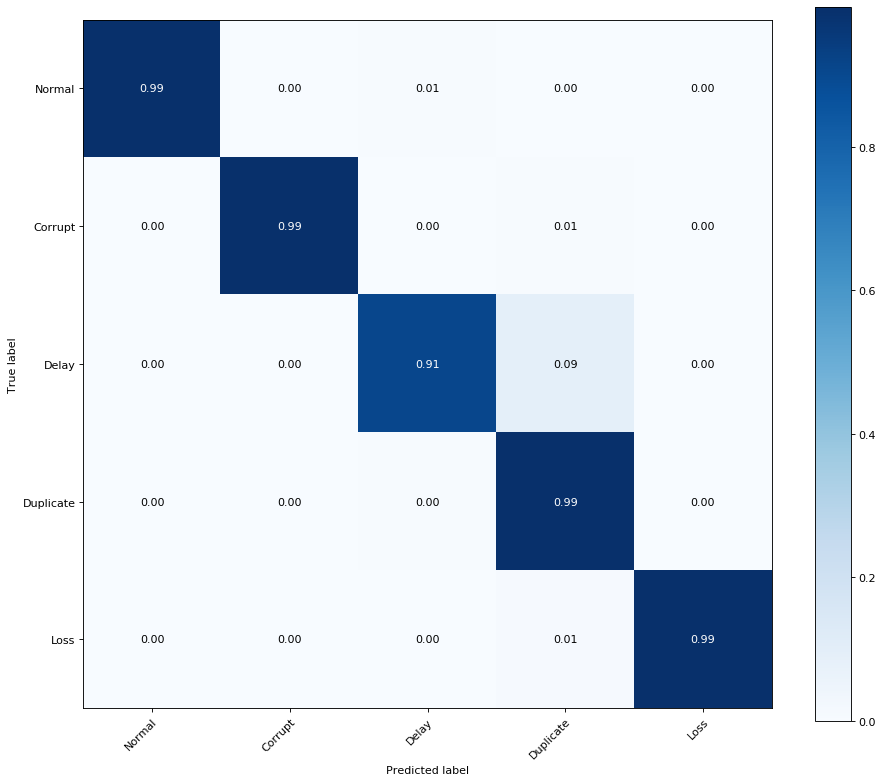

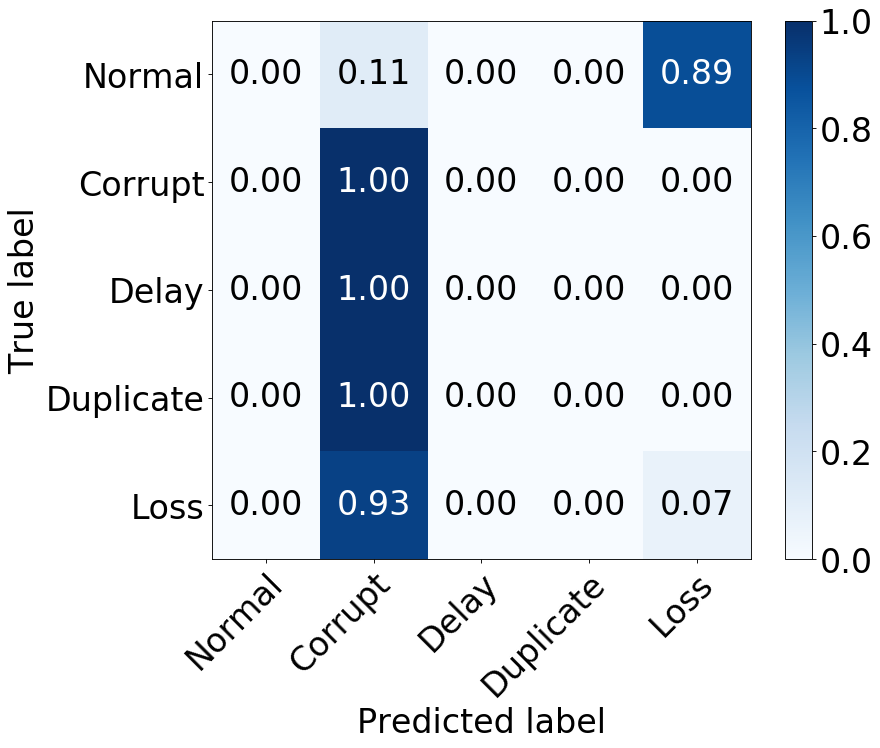

In [9]:
hpc =  DecisionTreeClassifier()
hpc.fit(hpc_train_data, hpc_train_labels)
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_DT_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_DT.pdf')
plt.show()

dtn_predicted_labels = hpc.predict(dtn_test_data)
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.show()







## RF :



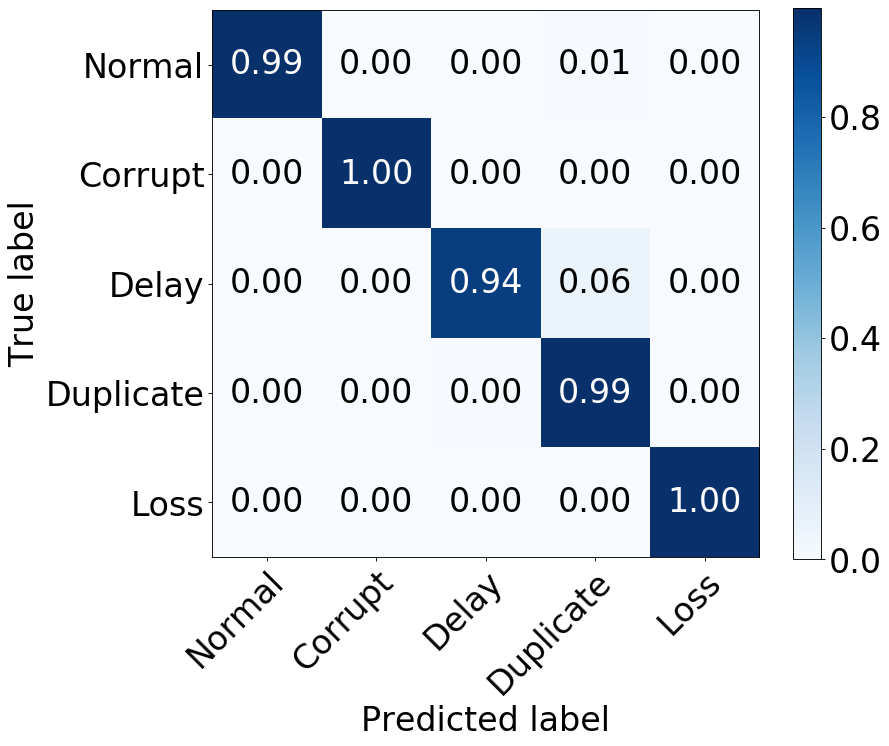

In [10]:

hpc =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
hpc.fit(hpc_train_data, hpc_train_labels)
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_RF_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_RF.pdf')
plt.show()



## SVM :

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


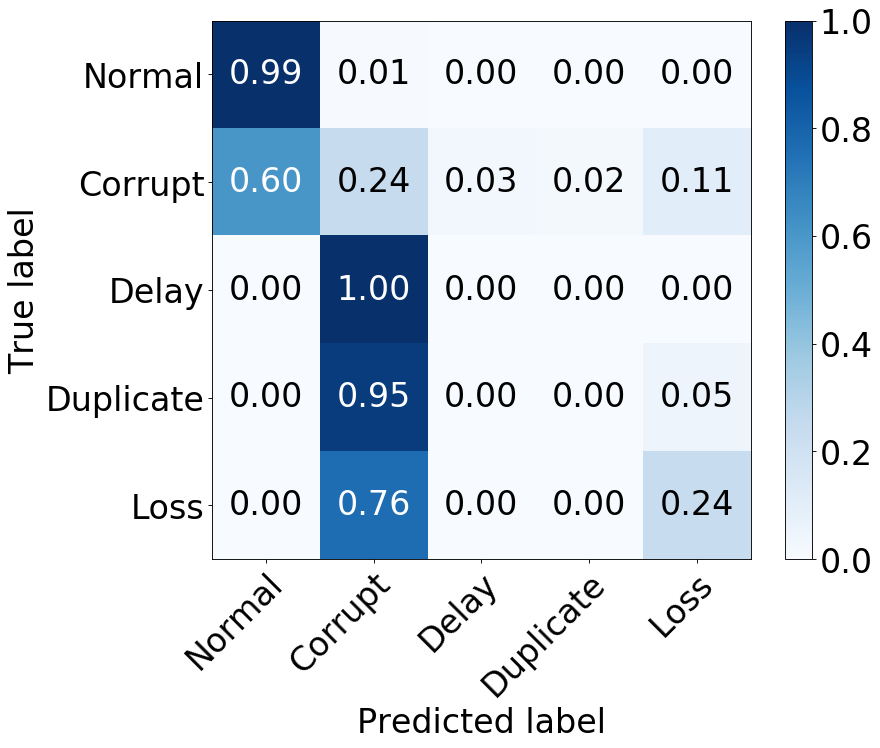

In [11]:




hpc = svm.SVC(kernel='linear', gamma ='auto', max_iter=100)
hpc.fit(hpc_train_data, hpc_train_labels)
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_SVM_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_SVM.pdf')
plt.show()




## NN :

In [12]:


#create model
model = Sequential()

#get number of columns in training data
n_cols = hpc_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

hpc_train_labels = to_categorical(hpc_train_labels)
dtn_train_labels = to_categorical(dtn_train_labels)
model.fit(dtn_train_data, dtn_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
hpc_predicted_labels = model.predict(hpc_test_data)
plot_confusion_matrix(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.show()


K.clear_session()
model.fit(hpc_train_data, hpc_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_NN_CR.csv", sep='\t')


dtn_predicted_labels = model.predict(dtn_test_data)
plot_confusion_matrix(dtn_test_labels,  np.argmax(dtn_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.show()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




ValueError: Error when checking target: expected dense_4 to have shape (6,) but got array with shape (1,)